In [3]:
from random import * 
import math 
import numpy as np 
import scipy 
from scipy import optimize
from matplotlib import pyplot as plt
from tqdm import tqdm 
from scipy.integrate import quad # for numerical integrals
from alphaS import * 

#Inizializzo alphaS passando come riferimento la massa dello Z
aS=alphaS(0.118,91.186)
# RUN OPTIONS
# Numero di linee di quark da simulare
Nevolve = 100000
# scala del cutoff
Qc = 1.
# the hard scale, e.g. 1000 GeV
Q = 500.
scaleoption="fixed" #alternativa 'pt' 
fixedscale=Q/2.


def get_alphaS_over():
    
    if scaleoption == "pt":
        minscale = Qc # the minimum scale^2 available to the PDF
        scale = minscale
        
    elif scaleoption == "fixed":
        scale = fixedscale
        
    alphaS_over = aS.alphasQ(scale)/2./math.pi
    
    return alphaS_over


def tGamma(z):
    return -2*get_alphaS_over()*CF*np.log(1.-z)

def Inverse_tGamma(y):
     return 1. - np.exp(- 0.5*y/CF/get_alphaS_over())

def rho(z1,z2):
    return tGamma(z1)-tGamma(z2)
    

def zp_over(t):
    return 1-np.sqrt(Qc**2/t)
def zm_over(t):
    return np.sqrt(Qc**2/t)



def g(t):

    def integrand(x):
        return rho(zp_over(x),zm_over(x))/x

    result,error=quad(integrand,100,t)

    return result




Definiamo la funzione  $\rho({\hat{z(t')}_+},{\hat{z(t')}_-}) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = t'\hat{\Gamma} (t') $, to obtain:

$\int^{t_\mathrm{max}}_{t} \frac{\mathrm{d}t'}{t'} \rho(t') = \ln\left(\frac{1}{R}\right)$, 

or:

$\int^{t_\mathrm{max}}_{t} \mathrm{d}\ln t' \rho(t) = \ln\left(\frac{1}{R}\right)$.

Sia $G(t)=\int^{t}_{} \mathrm{d}\ln t' \rho(t')$.

$G(t_{max})-G(t)=\ln(\frac{1}{R})$
$G(t)=G(t_{max})-\ln(\frac{1}{R})$
$t=G^{-1}(G(t_{max})-ln(\frac{1}{R}))$




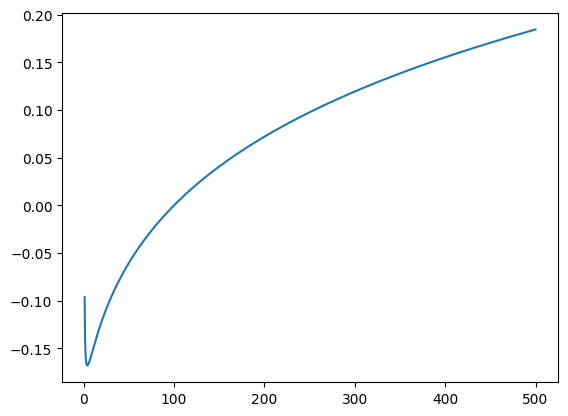

In [4]:
t_plot=np.linspace(Qc,Q,1000)
g_plot=np.vectorize(g)
plt.plot(t_plot,g_plot(t_plot))



In [ ]:
def EmissionScaleFunc(logt_over_Qsq,Q,R):

    t = Q**2 * np.exp( logt_over_Qsq )
    
    r=rho(zp_over(t),zm_over(t))

    return logt_over_Qsq-(1./r)*np.log(R)


def Get_tEmission(Q, tfac,R):

    tolerance = 1E-3 # the tolerance for the solution

    EmissionFunc_arg = lambda x : EmissionScaleFunc(x, Q,R) # the function in a form appropriate for the solver

    # calculate the solution using "Ridder's" method

    lower_bound=np.log(tfac*Qc**2/Q**2)
    upper_bound=0.

    sol, results = scipy.optimize.ridder(EmissionFunc_arg, lower_bound, upper_bound, xtol=tolerance, full_output=True, maxiter=1000)

    tEm = Q**2 * np.exp( sol )

    # if a solution has not been found, terminate the evolution 
    #        
    if abs(EmissionFunc_arg(sol)) > tolerance:
            return Q**2, [], False
            
    # otherwise return the emission scale and continue
    return tEm, results, True



    #
def Generate_Emission(Q, tfac):
    
    generated = True

    R1 = random()
    R2 = random()
    R3 = random() #veto test over z
    R4 = random() #veto test over t
    
    # solve for the (candidate) emission scale:

    tEm, results, continueEvolution = Get_tEmission(Q,tfac,R1)
    
    # if no solution is found then end branch

    if continueEvolution == False:
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

    
    
    # get the (candidate) z of the emission
    zEm = Get_zEmission(tEm,R2)
    
    # get the transverse momentum 
    pTsqEm = Get_pTsq(tEm, zEm)
    # get the virtual mass squared:
    MsqEm = Get_mvirtsq(tEm, zEm)

    # now check the conditions to accept or reject the emission:
    # check if the transverse momentum is physical:
    if pTsqEm < 0.:
      
        generated = False
        
    # compare the splitting function overestimate prob to a random number
    if (Pqq(zEm)/Pqq_over(zEm))*(alphaS(tEm, zEm)/get_alphaS_over()) < R3:
        generated = False
    
    # compare the alphaS overestimate prob to a random number

    #if alphaS(tEm, zEm)/get_alphaS_over() < R4:
    #    generated = False
    
   
    if generated == False: # rejected emission
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        
    # return all the variables for the emission
    return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

In [51]:
import ROOT
import math as m


#funzione che mi ritorna gli angoli di emissione, cioè quelli nel sistema in cui il quark è lungo l'asse z'

def angles(pt,z,Ei):

    sin_theta=pt/m.sqrt(pt**2+z**2*Ei**2)
    phi=1+2*np.pi*random()
    return m.asin(sin_theta),phi

#funzione che ritorna il quadrivettore nella giusta direzione

def rotated_3p(P):

    p_mag=np.sqrt(P[0]**2+P[1]**2+P[2]**2)

    u=P[0]/p_mag
    v=P[1]/p_mag
    w=P[2]/p_mag
    
    theta=P.Theta()
    phi=P.Phi()

    if w!=1:
        u_star=u*m.cos(theta)+(1./m.sqrt(1-w**2))*m.sin(theta)*(u*w*m.cos(phi)-v*m.sin(phi))
        v_star=v*m.cos(theta)+(1./m.sqrt(1-w**2))*m.sin(theta)*(v*w*m.cos(phi)+u*m.sin(phi))
        w_star=w*m.cos(theta)-m.sqrt(1-w**2)*m.sin(theta)*m.cos(theta)

    return p_mag*ROOT.TVector3(u_star,v_star,w_star)


#funzione che aggiorna il 4-impulso del gluone dopo l'emissione dati z e pt generati e il quadrivettore prima dell'emissione e ritorna il 
#quadrimpulso del gluone 


def generate_4vectors(pq_old,pT,z):

    Ei=pq_old[3]
   
    E_q_new= z*Ei
    pz_new=m.sqrt(z**2*Ei**2-pT**2)

    theta_em,phi_em=angles(pT,z,Ei)

    p_q_new=ROOT.TLorentzVector(pT*m.cos(phi_em),pT*m.sin(phi_em),pz_new,E_q_new)
    
    p3_new=rotated_3p(p_q_new)

    pq_old_tmp=ROOT.TLorentzVector(pq_old)

    pq_old.SetPxPyPzE(p3_new[0],p3_new[1],p3_new[2],p_q_new[3])

    pg=pq_old_tmp-pq_old

    return pg



In [62]:

Qstart=1000
pq=ROOT.TLorentzVector(0,0,Qstart,Qstart) #terrò sempre questo quadrivettore aggiornandolo.

In [84]:
ptz_list=np.array([[631.084907902719, 0.9388197783066125, 36.24775143971034, 151.24618632881376],
 [503.3687629062982, 0.9088687039517107, 41.69221391089772, 144.8673812117598],
 [441.8200507831675,
  0.9953739270644192,
  2.0344365868813616,
  29.980908527445546]])

def pt_sign(list):

    for i in range(len(list)):
        r=random()
        if r>0.5:
            list[i,2]=(-1)*list[i,2]
            
       
pt_sign(ptz_list)






In [82]:
Qstart=1000
pq=ROOT.TLorentzVector(0,0,Qstart,Qstart) #terrò sempre questo quadrivettore aggiornandolo

def get_gluons(event):


    first_emission=True
    gluons_list=[]

    for emission in event:

        pT=emission[2]
        z=emission[1]
        
        if first_emission==True:
            
            E=pq.E()
            phi0=2*np.pi*random()+1
            pq.SetPxPyPzE(pT*np.cos(phi0),pT*np.sin(phi0),z*E,z*E)

            pg_first=ROOT.TLorentzVector(-pT*np.cos(phi0),-pT*np.sin(phi0),(1-z)*E,(1-z)*E)
            gluons_list.append(pg_first)
            first_emission==False

        if first_emission==False:

            pg=generate_4vectors(pq,pT,z)
            gluon_list.append(pg)


    return gluons_list

gluon_list=get_gluons(ptz_list)


len(gluon_list)
            
        






3

In [ ]:
def get_Thrust(gluon_list):

    pt_sum=0
    pmag_sum=0
    for gluon in gluon_list:
        n=ROOT.TVector3(0,0,1)
        p=gluon.Vect()
        p_dot_n=n.Dot(p)
        pt_sum=pt_sum +p_dot_n
        pmag_sum=pmag_sum+p.Mag()


    Thrust=pt_sum/pmag_sum
    return Thrust



